## Using Siphon to query the NetCDF Subset Service and plotting it to a map

This example uses Siphon's NCSS class to provide temperature data for contouring a basic map using Cartopy

First we construct a `TDSCatalog` instance pointing to our dataset of interest, in
this case TDS' "Best" virtual dataset for the GFS global 0.25 degree collection of
GRIB files. This will give us a good resolution for our map. This catalog contains a single dataset.

In [1]:
from siphon.catalog import TDSCatalog
best_gfs = TDSCatalog('http://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/'
                      'Global_0p25deg/catalog.xml?dataset=grib/NCEP/GFS/Global_0p25deg/Best')
print(list(best_gfs.datasets))

['Best GFS Quarter Degree Forecast Time Series']


We pull out this dataset and look at the access urls.

In [2]:
best_ds = list(best_gfs.datasets.values())[0]
best_ds.access_urls

{'CdmRemote': 'http://thredds.ucar.edu/thredds/cdmremote/grib/NCEP/GFS/Global_0p25deg/Best',
 'ISO': 'http://thredds.ucar.edu/thredds/iso/grib/NCEP/GFS/Global_0p25deg/Best',
 'NCML': 'http://thredds.ucar.edu/thredds/ncml/grib/NCEP/GFS/Global_0p25deg/Best',
 'NetcdfSubset': 'http://thredds.ucar.edu/thredds/ncss/grib/NCEP/GFS/Global_0p25deg/Best',
 'OPENDAP': 'http://thredds.ucar.edu/thredds/dodsC/grib/NCEP/GFS/Global_0p25deg/Best',
 'UDDC': 'http://thredds.ucar.edu/thredds/uddc/grib/NCEP/GFS/Global_0p25deg/Best',
 'WCS': 'http://thredds.ucar.edu/thredds/wcs/grib/NCEP/GFS/Global_0p25deg/Best',
 'WMS': 'http://thredds.ucar.edu/thredds/wms/grib/NCEP/GFS/Global_0p25deg/Best'}

Note the `NetcdfSubset` entry, which we will use with our NCSS class.

In [3]:
from siphon.ncss import NCSS
ncss = NCSS(best_ds.access_urls['NetcdfSubset'])

We can then use the `ncss` object to create a new query object, which
facilitates asking for data from the server.

In [4]:
query = ncss.query()

We construct a query asking for data corresponding to a latitude and longitude box where 43 lat is the northern extent, 35 lat is the southern extent, -111 long is the western extent and -100 is the eastern extent. We request the data for the current time.

We also ask for NetCDF version 4 data, for the variable 'temperature_surface'. This request will return all surface temperatures for points in our bounding box for a single time, nearest to that requested. Note the string representation of the query is a properly encoded query string.

In [5]:
from datetime import datetime
query.lonlat_box(north=43, south=35, east=-100, west=-111).time(datetime.utcnow())
query.accept('netcdf4')
query.variables('Temperature_surface')

var=Temperature_surface&time=2016-04-04T21%3A41%3A12.148123&east=-100&west=-111&south=35&north=43&accept=netcdf4

We now request data from the server using this query. The `NCSS` class handles parsing this NetCDF data (using the `netCDF4` module). If we print out the variable names, we see our requested variable, as well as the coordinate variables (needed to properly reference the data).

In [6]:
data = ncss.get_data(query)
print(list(data.variables))

['Temperature_surface', 'reftime1', 'time1', 'lat', 'lon']


We'll pull out the useful variables for temperature, latitude, and longitude, and time (which is the time, in hours since the forecast run). 

In [7]:
temp_var = data.variables['Temperature_surface']

# Time variables can be renamed in GRIB collections. Best to just pull it out of the
# coordinates attribute on temperature
time_name = temp_var.coordinates.split()[1]
time_var = data.variables[time_name]
lat_var = data.variables['lat']
lon_var = data.variables['lon']

Now we make our data suitable for plotting.

In [8]:
import numpy as np
from netCDF4 import num2date

# Get the actual data values and remove any size 1 dimensions
temp_vals = temp_var[:].squeeze()
lat_vals = lat_var[:].squeeze()
lon_vals = lon_var[:].squeeze()

# Convert the number of hours since the reference time to an actual date
time_val = num2date(time_var[:].squeeze(), time_var.units)

# Convert temps to Fahrenheit from Kelvin
temp_vals = temp_vals * 1.8 - 459.67

# Combine 1D latitude and longitudes into a 2D grid of locations
lon_2d, lat_2d = np.meshgrid(lon_vals, lat_vals)

Now we can plot these up using matplotlib and cartopy.

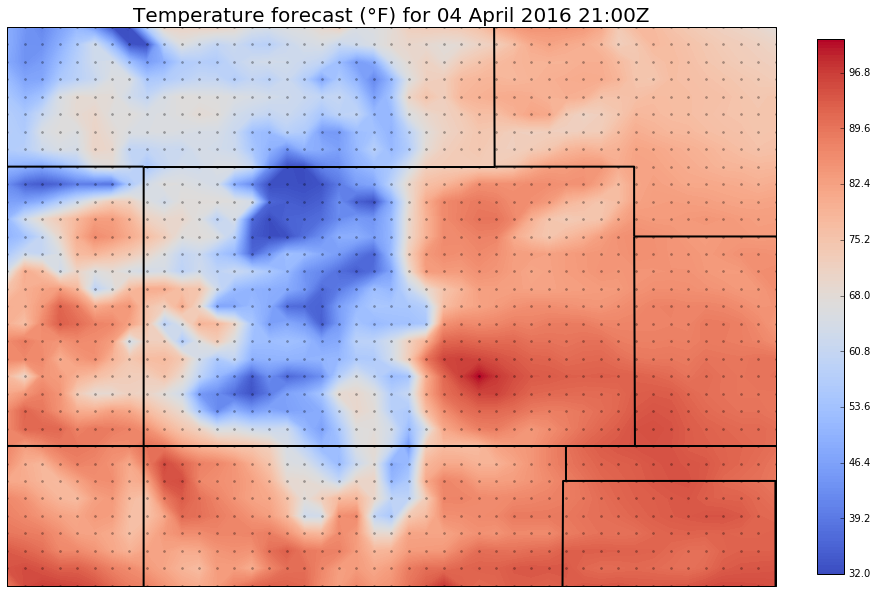

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Create a new figure
fig = plt.figure(figsize=(15, 12))

# Add the map and set the extent
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-100., -111., 35, 43])

# Add state boundaries to plot
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
ax.add_feature(states_provinces, edgecolor='black', linewidth=2)

# Contour temperature at each lat/long
cf = ax.contourf(lon_2d, lat_2d, temp_vals, 200, transform=ccrs.PlateCarree(), zorder=0,
                 cmap='coolwarm')

# Plot a colorbar to show temperature and reduce the size of it
plt.colorbar(cf, ax=ax, fraction=0.032)

# Make a title with the time value
ax.set_title(u'Temperature forecast (\u00b0F) for {0:%d %B %Y %H:%MZ}'.format(time_val),
             fontsize=20)

# Plot markers for each lat/long to show grid points for 0.25 deg GFS
ax.plot(lon_2d.flatten(), lat_2d.flatten(), marker='o', color='black', markersize=2,
        alpha=0.3, transform=ccrs.Geodetic(), zorder=2, linestyle='none');